In [13]:
#Modified from https://github.com/choldgraf/write-ups/blob/master/comp/craigslist_scrape.ipynb
import pandas as pd
from time import sleep
import numpy as np
import requests
from bs4 import BeautifulSoup as bs4
import seaborn as sns

%matplotlib inline

In [14]:
loc_prefixes = ['sfc']
#loc_prefixes = ['eby', 'nby', 'sfc', 'sby', 'scz']


In [15]:
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

# no addresses in search results only in post page itself
def find_address(results):
    address = []
    for rw in results:
        address = rw.find()
        if time is not None:
            time = time['datetime']
            time = pd.to_datetime(time)
        else:
            time = np.nan
        times.append(time)
    return times

In [16]:
def find_size_and_brs(size):
    split = size.strip('/- ').split(' - ')
    if len(split) == 2:
        n_brs = split[0].replace('br', '')
        this_size = split[1].replace('ft2', '')
    elif 'br' in split[0]:
        # It's the n_bedrooms
        n_brs = split[0].replace('br', '')
        this_size = -1
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].replace('ft2', '')
        n_brs = -1
    return float(this_size), float(n_brs)


In [17]:
results = []  # We'll store the data here
# Careful with this...too many queries == your IP gets banned temporarily
search_indices = np.arange(0, 300, 100)

In [18]:
def crawl_cl(pr, br, ba, radius=1, postal=94103):

    # Now loop through all of this and store the results
    results = []  # We'll store the data here

    #search_indices = np.arange(0, 300, 100)
    for loc in loc_prefixes:
        print loc
        for i in range(0,5):
            #print(i)
            url = 'http://sfbay.craigslist.org/search/{0}/apa'.format(loc)
            # 1 mile radius from soma/civic center
            resp = requests.get(url, params={'bedrooms': br, 'max_price':pr, 'bathrooms':ba, \
                                             'search_distance': radius, 'postal':postal, 's': i})
            print resp.url
            txt = bs4(resp.text, 'html.parser')
            apts = txt.findAll(attrs={'class': "row"})
            #print(apts)
            # Find the size of all entries
            size_text = [rw.findAll(attrs={'class': 'housing'})[0].text
                         for rw in apts]
            #print(size_text)
            sizes_brs = [find_size_and_brs(stxt) for stxt in size_text]
            #print(sizes_brs)
            sizes, n_brs = zip(*sizes_brs)  # This unzips into 2 vectors

            # Find the title and link
            title = [rw.find('a', attrs={'class': 'hdrlnk'}).text
                          for rw in apts]
            links = ['https://sfbay.craigslist.org'+rw.find('a', attrs={'class': 'hdrlnk'})['href']
                     for rw in apts]

            hood = [rw.find('span', {'class': 'pnr'}).text.split('   ')[0][3:-1] for rw in apts]
            # Find the time
            time = [pd.to_datetime(rw.find('time')['datetime']) for rw in apts]
            price = find_prices(apts)

            #create price per sq ft
            pricepersqft = [price[a]/sizes[a] for a in range(0,len(price))]

            # We'll create a dataframe to store all the data
            data = np.array([time, price, sizes, pricepersqft, n_brs, title, hood, links])
            col_names = ['time', 'price', 'size', 'pricepersqft','brs', 'title', 'neighborhood', 'link']
            df = pd.DataFrame(data.T, columns=col_names)
            df = df.set_index('time')

            # Add the location variable to all entries
            #df['loc'] = loc
            results.append(df)
            #sleep 30 seconds
            sleep_amt = np.random.randint(20, 60)
            sleep(sleep_amt)
    # Finally, concatenate all the results
    results = pd.concat(results, axis=0)
    return results

In [19]:
results = crawl_cl(3500, 1, 1)

sfc
http://sfbay.craigslist.org/search/sfc/apa?bathrooms=1&bedrooms=1&search_distance=1&s=0&postal=94103&max_price=3500
http://sfbay.craigslist.org/search/sfc/apa?bathrooms=1&bedrooms=1&search_distance=1&s=1&postal=94103&max_price=3500
http://sfbay.craigslist.org/search/sfc/apa?bathrooms=1&bedrooms=1&search_distance=1&s=2&postal=94103&max_price=3500
http://sfbay.craigslist.org/search/sfc/apa?bathrooms=1&bedrooms=1&search_distance=1&s=3&postal=94103&max_price=3500
http://sfbay.craigslist.org/search/sfc/apa?bathrooms=1&bedrooms=1&search_distance=1&s=4&postal=94103&max_price=3500


In [20]:
results = results[results['brs']==1].drop_duplicates() #only looking for 1 bedrooms, cl returns 1+

In [21]:
results.describe()

,price,size,pricepersqft,brs,title,neighborhood,link
count,78.0,78.0,78.0,78.0,78,78,78
unique,44.0,24.0,56.0,1.0,75,12,78
top,3495.0,-1.0,-3495.0,1.0,"SoMa - Jr 1 BR, 1 BA Condo 530 Sq. Ft. - Near ...",SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/559236672...
freq,9.0,50.0,8.0,78.0,2,20,1


In [22]:
withsqft = results[results['pricepersqft']>0]

In [23]:
pd.set_option('max_colwidth',100)

In [24]:
withsqft.sort_values(['pricepersqft'], ascending=True)

,price,size,pricepersqft,brs,title,neighborhood,link
time,,,,,,,
2016-05-18 10:36:00,3000,13000,0.230769,1,"RENT MASTER BEDROOM IN LUXURY CONDO - 3,000",SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5592527014.html
2016-05-18 16:07:00,2500,753,3.32005,1,Hot! Victorian Secret! Open 5/19/16 at 5-7:00pm,hayes valley,https://sfbay.craigslist.org/sfc/apa/5593116160.html
2016-05-17 14:23:00,3500,950,3.68421,1,Beautiful furnished apartment in Haight- Buena Vista Park,San Francisco,https://sfbay.craigslist.org/sfc/apa/5579591985.html
2016-05-18 07:16:00,2395,587,4.08007,1,Charming 1 Bedroom! Bright Eastern Views~Virtual Tour!,SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5592148621.html
2016-05-18 11:29:00,3400,800,4.25,1,"1 bed 1 bath, huge walk in closet - ONE MONTH FREE, READY NOW!",financial district,https://sfbay.craigslist.org/sfc/apa/5592646272.html
2016-05-18 09:01:00,3300,769,4.29129,1,"Downtown - 1 BR, 1 BA Condo, 769 Sq. Ft. - The Historic Garfield",downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5592347563.html
2016-05-18 10:53:00,2595,602,4.31063,1,"455 Eddy #1007 - 1 bedroom (24/7 security, balcony, close to BART)",tenderloin,https://sfbay.craigslist.org/sfc/apa/5553212393.html
2016-05-17 15:39:00,2000,450,4.44444,1,TL Quite Rear Jr One Bedroom,tenderloin,https://sfbay.craigslist.org/sfc/apa/5587671337.html
2016-05-17 18:50:00,2950,650,4.53846,1,Charming Traditional Decor Unit in Convenient Location,SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5581941807.html


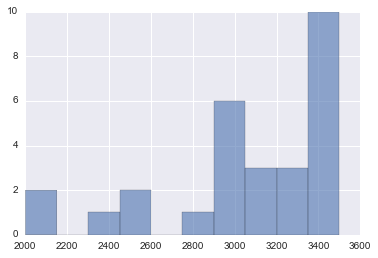

In [25]:
withsqft.price.hist(alpha=.6)

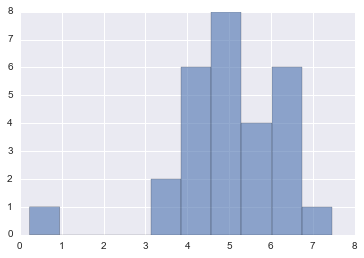

In [26]:
withsqft.pricepersqft.hist(alpha=.6)

In [27]:
withoutsqft = results[results['pricepersqft']<0]

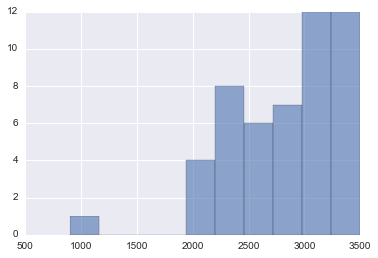

In [28]:
withoutsqft.price.hist(alpha=.6)

In [29]:
withoutsqft.sort_values(['price'], ascending=True)

,price,size,pricepersqft,brs,title,neighborhood,link
time,,,,,,,
2016-05-18 09:29:00,900,-1,-900,1,Bright renovated 1 bedroom apartment in SOMA,SOMA / south beach,https://sfbay.craigslist.org/sfc/apa/5592366725.html
2016-05-18 16:31:00,2095,-1,-2095,1,One Bedroom in Historic Pet-friendly Building! 360 Hyde Street #308,tenderloin,https://sfbay.craigslist.org/sfc/apa/5556577625.html
2016-05-18 12:00:00,2095,-1,-2095,1,"Open House Today, Wed., 5/18, 7:00pm - 7:30pm, 360 Hyde St.",tenderloin,https://sfbay.craigslist.org/sfc/apa/5592705710.html
2016-05-18 14:43:00,2100,-1,-2100,1,Remodeled Jr. One Bedroom,downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5578125539.html
2016-05-18 13:35:00,2195,-1,-2195,1,The Special!,tenderloin,https://sfbay.craigslist.org/sfc/apa/5592870426.html
2016-05-18 11:45:00,2295,-1,-2295,1,"Bright, Cozy & Clean. Need I say More: #242",tenderloin,https://sfbay.craigslist.org/sfc/apa/5592661698.html
2016-05-18 11:54:00,2395,-1,-2395,1,Wait till you see this! Jr.1 bedroom: #406,tenderloin,https://sfbay.craigslist.org/sfc/apa/5589011369.html
2016-05-18 12:23:00,2395,-1,-2395,1,Tenderloin Junior 1BD Apartment,downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5592749023.html
2016-05-18 09:28:00,2395,-1,-2395,1,"Tenderloin Junior One Bedroom - Modern, Newly Renovated!",downtown / civic / van ness,https://sfbay.craigslist.org/sfc/apa/5587513928.html


In [30]:
withsqft.to_csv('resultsqft.csv')
withoutsqft.to_csv('resultnosqft.csv')

In [31]:
import string
use_chars = string.ascii_letters +\
    ''.join([str(i) for i in range(10)]) +\
    ' /\.'
#print(use_chars)
withsqft['title'] = withsqft['title'].apply(
    lambda a: ''.join([i for i in a if i in use_chars]))

withsqft.to_csv('resultsqft_nospecialchars.csv')

C:\Users\Li\Anaconda3\envs\snowflakes\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
